In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [2]:
# retrieve Seller dataset from seller.py file
from olist.seller import Seller
sellers = Seller().get_training_data()

# create DataFrame that will exclude all the unnecessary columns
sellers_prep = sellers[['seller_id','months_on_olist', 'sales','quantity']]


In [3]:
# create a new column(revenue_from_seller) that adds the monthly fee costs (months * 80) and the 10% cut from the sales
sellers_prep['revenue_from_seller'] = (sellers_prep['months_on_olist'] * 80) + (sellers_prep['sales'] * 0.1)

/tmp/ipykernel_874/633802015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_prep['revenue_from_seller'] = (sellers_prep['months_on_olist'] * 80) + (sellers_prep['sales'] * 0.1)


In [4]:
# import all the CSVs so that we can use them down below. 
from olist.data import Olist
olist = Olist()
data = olist.get_data()

# create DataFrame's that will exclude all the unnecessary columns
reviews = data['order_reviews'][['order_id', 'review_score']]
items = data['order_items'][['order_id', 'seller_id']]

# create a function that applies the cost per review_score 
def calculate_review_cost(score):
    if score == 1:
        return 100
    elif score == 2:
        return 50
    elif score == 3:
        return 40
    else:
        return 0

# apply the function above using the ".apply" and assign the cost to a new column called "review_cost"
reviews['review_cost'] = reviews['review_score'].apply(calculate_review_cost)

# merge items df to reviews df
review_cost_mapped = pd.merge(reviews, items, on='order_id')

review_cost_mapped

/tmp/ipykernel_874/3812642674.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['review_cost'] = reviews['review_score'].apply(calculate_review_cost)


,order_id,review_score,review_cost,seller_id
0,73fc7af87114b39712e6da79b0a377eb,4,0,6d803cb79cc31c41c4c789a75933b3c7
1,73fc7af87114b39712e6da79b0a377eb,4,0,6d803cb79cc31c41c4c789a75933b3c7
2,a548910a1c6147796b98fdf73dbeba33,5,0,8e6d7754bc7e0f22c96d255ebda59eba
3,f9e4b658b201a9f2ecdecbb34bed034b,5,0,a1043bafd471dff536d0c462352beb48
4,658677c97b385a9be170737859d3511b,5,0,a1043bafd471dff536d0c462352beb48
...,...,...,...,...
112367,2a8c23fee101d4d5662fa670396eb8da,5,0,5343d0649eca2a983820bfe93fc4d17e
112368,22ec9f0669f784db00fa86d035cf8602,5,0,46dc3b2cc0980fb8ec44634e21d2718e
112369,55d4004744368f5571d1f590031933e4,5,0,17ca9b9e9b9ef8fdb529001b49ebb50f
112370,7725825d039fc1f0ceb7635e3f7d9206,4,0,8d956fec2e4337affcb520f56fd8cbfd


In [5]:
# count the number of unique sellers for each order_id
seller_counts = review_cost_mapped.groupby('order_id')['seller_id'].nunique()

# divide the review_cost equally among the unique sellers for each order_id
review_cost_mapped['review_cost'] = review_cost_mapped['review_cost'] / seller_counts[review_cost_mapped['order_id']].values

# group the data by seller_id and sum the review_cost
result = review_cost_mapped.groupby('seller_id')['review_cost'].sum()

result

seller_id
0015a82c2db000af6aaaf3ae2ecb0532     100.0
001cca7ae9ae17fb1caed9dfb1094831    4700.0
001e6ad469a905060d959994f1b41e4f     100.0
002100f778ceb8431b7a1020ff7ab48f    1060.0
003554e2dce176b5555353e4f3555ac8       0.0
                                     ...  
ffcfefa19b08742c5d315f2791395ee5     100.0
ffdd9f82b9a447f6f8d4b91554cc7dd3     240.0
ffeee66ac5d5a62fe688b9d26f83f534     200.0
fffd5413c0700ac820c7069d66d98c89    1220.0
ffff564a4f9085cd26170f4732393726    1420.0
Name: review_cost, Length: 3090, dtype: float64

In [6]:
# merge result df to sellers_prep df
sellers_copy = sellers_prep.merge(result, on="seller_id")

sellers_final = sellers_copy[['seller_id','revenue_from_seller','review_cost','quantity']]

# create new column "profit" where we subtract the cost from the revenue of the seller
sellers_final['profit'] = sellers_final['revenue_from_seller'].round(2) - sellers_final['review_cost'].round(2)

sellers_final

/tmp/ipykernel_874/1029515366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_final['profit'] = sellers_final['revenue_from_seller'].round(2) - sellers_final['review_cost'].round(2)


,seller_id,revenue_from_seller,review_cost,quantity,profit
0,3442f8959a84dea7ee197c632cb2df15,341.870,120.0,3,221.87
1,d1b65fc7debc3361ea86b5f14c68d2e2,2290.307,240.0,41,2050.31
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800,0.0,1,15.80
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999,0.0,1,8.00
4,51a04a8a6bdcb23deccc82b0b80742cf,16.799,100.0,1,-83.20
...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,15.800,0.0,2,15.80
2963,f8201cab383e484733266d1906e2fdfa,1208.900,140.0,10,1068.90
2964,74871d19219c7d518d0090283e03c137,455.004,0.0,7,455.00
2965,e603cf3fec55f8697c9059638d6c8eb5,349.700,50.0,11,299.70


In [7]:
# sort sellers_final df by profit + Ascending
sorted_df = sellers_final.sort_values(by=['profit'],ascending=True)

sellers_profitable = sorted_df

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

In [8]:
# find an optimal number of sellers to remove that maximizes either
# Olist's profit margin or profit.

In [9]:
# calculating IT Costs with
sqrt_len = (len(sellers_profitable))**0.5
sqrt_sum = sellers_profitable['quantity'].sum()**0.5

sellers_profitable['it_with'] = 3157.27 * sqrt_len + 978.23 * sqrt_sum

# calculating IT Costs without
sqrt_len_without = (len(sellers_profitable) - 1)**0.5
sqrt_sum_without = (sellers_profitable['quantity'].sum() - sellers_profitable['quantity'])**0.5
sellers_profitable['it_without'] = 3157.27 * sqrt_len_without + 978.23 * sqrt_sum_without

# calculating the difference between WITH & WITHOUT
sellers_profitable['it_diff'] = sellers_profitable['it_with'] - sellers_profitable['it_without']

# calculating the profit margin
sellers_profitable['profit_margin'] = sellers_profitable['profit'] - sellers_profitable['it_diff']


sellers_profitable

,seller_id,revenue_from_seller,review_cost,quantity,profit,it_with,it_without,it_diff,profit_margin
769,6560211a19b47992c3666cc44a7e94c0,13770.483,39163.333333,2033,-25392.85,499999.318519,496991.389117,3007.929402,-28400.779402
453,1f50f920176fa81dab994f9023523100,12053.921,35923.333333,1931,-23869.41,499999.318519,497141.499458,2857.819061,-26727.229061
1132,7c67e1448b00f6e969d365cea6b010ab,20232.389,43920.000000,1364,-23687.61,499999.318519,497974.676424,2024.642095,-25712.252095
2358,4a3ca9315b744ce9f8e9374361493884,21647.292,42176.666667,1987,-20529.38,499999.318519,497059.094518,2940.224002,-23469.604002
1357,cc419e0650a3c5ba77189a1882b7556a,11948.842,30950.000000,1775,-19001.16,499999.318519,497370.946047,2628.372473,-21629.532473
...,...,...,...,...,...,...,...,...,...
2830,46dc3b2cc0980fb8ec44634e21d2718e,14571.119,7780.000000,542,6791.12,499999.318519,499178.795606,820.522913,5970.597087
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,8808.455,1550.000000,175,7258.46,499999.318519,499714.972737,284.345782,6974.114218
67,7e93a43ef30c4f03f38b393420bc753a,19323.187,4715.000000,340,14608.19,499999.318519,499474.020778,525.297742,14082.892258
534,fa1c13f2614d7b5c4749cbc52fecda94,21004.203,6310.000000,586,14694.20,499999.318519,499114.453799,884.864720,13809.335280


In [10]:
global_profit_list=[]

sellers_graph=sellers_profitable
i=0
for seller in range(len(sellers_graph)):
    it_cost=3157.27*len(sellers_graph)**0.5+978.23*sellers_graph['quantity'].sum()**0.5
    global_profit=sellers_graph['profit'].sum()-it_cost
    global_profit_list.append((len(sellers_graph),global_profit))
    
    sellers_graph = sellers_graph.iloc[1:]
    i+=1
    sellers_graph['it_with']=3157.27*len(sellers_graph)**0.5+978.23*sellers_graph['quantity'].sum()**0.5
    sellers_graph['it_without']=3157.27*(len(sellers_graph)-1)**0.5+978.23*(sellers_graph['quantity'].sum()-sellers_graph['quantity'])**0.5
    sellers_graph['it_diff']=sellers_graph['it_with']-sellers_graph['it_without']
    sellers_graph['profit_margin']=sellers_graph['profit']-sellers_graph['it_diff']
    

/tmp/ipykernel_874/2507380571.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_graph['it_with']=3157.27*len(sellers_graph)**0.5+978.23*sellers_graph['quantity'].sum()**0.5
/tmp/ipykernel_874/2507380571.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_graph['it_without']=3157.27*(len(sellers_graph)-1)**0.5+978.23*(sellers_graph['quantity'].sum()-sellers_graph['quantity'])**0.5
/tmp/ipykernel_874/2507380571.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [24]:
df = pd.DataFrame(global_profit_list)
df.columns = ['number_sellers', 'global_profit']
df=df.reset_index()
df=df.rename(columns={'index': "numbers_sellers_removed"})
df.head(10)

,numbers_sellers_removed,number_sellers,global_profit
0,0,2967,386186.391481
1,1,2966,414587.170883
2,2,2965,441340.559107
3,3,2964,467089.184081
4,4,2963,490630.993911
5,5,2962,512350.209537
6,6,2961,531475.442719
7,7,2960,548672.702380
8,8,2959,566194.007312
9,9,2958,579297.958153


In [27]:
df["global_profit"].idxmax()

930

In [28]:
df.loc[930]

numbers_sellers_removed       930.000000
number_sellers               2037.000000
global_profit              986512.789282
Name: 930, dtype: float64

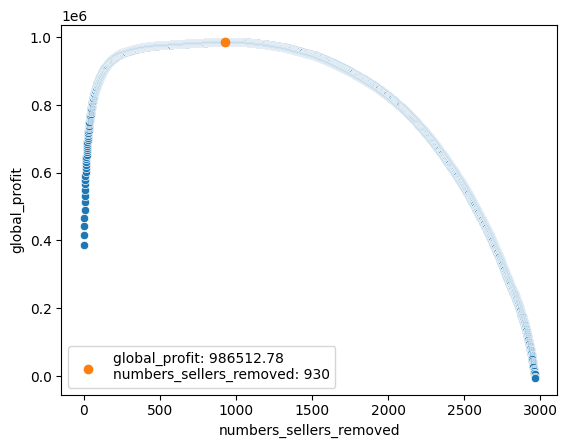

In [69]:
x = 930
y = 986512.789282

plt.figure()
sns.scatterplot(x='numbers_sellers_removed', y='global_profit', data = df)
plt.scatter(x, y, label="global_profit: 986512.78\nnumbers_sellers_removed: 930")
plt.legend()



In [13]:
# sort df by profit margin by Ascending
sellers_profitable = sellers_profitable.sort_values(by=['profit_margin'], ascending=True)

sellers_profitable

,seller_id,revenue_from_seller,review_cost,quantity,profit,it_with,it_without,it_diff,profit_margin
769,6560211a19b47992c3666cc44a7e94c0,13770.483,39163.333333,2033,-25392.85,499999.318519,496991.389117,3007.929402,-28400.779402
453,1f50f920176fa81dab994f9023523100,12053.921,35923.333333,1931,-23869.41,499999.318519,497141.499458,2857.819061,-26727.229061
1132,7c67e1448b00f6e969d365cea6b010ab,20232.389,43920.000000,1364,-23687.61,499999.318519,497974.676424,2024.642095,-25712.252095
2358,4a3ca9315b744ce9f8e9374361493884,21647.292,42176.666667,1987,-20529.38,499999.318519,497059.094518,2940.224002,-23469.604002
1357,cc419e0650a3c5ba77189a1882b7556a,11948.842,30950.000000,1775,-19001.16,499999.318519,497370.946047,2628.372473,-21629.532473
...,...,...,...,...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,8920.462,2200.000000,192,6720.46,499999.318519,499690.155569,309.162950,6411.297050
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,8808.455,1550.000000,175,7258.46,499999.318519,499714.972737,284.345782,6974.114218
534,fa1c13f2614d7b5c4749cbc52fecda94,21004.203,6310.000000,586,14694.20,499999.318519,499114.453799,884.864720,13809.335280
67,7e93a43ef30c4f03f38b393420bc753a,19323.187,4715.000000,340,14608.19,499999.318519,499474.020778,525.297742,14082.892258


In [14]:
# loop through sellers where profit margin is negative and remove one by one. 

i=0
while sellers_profitable.iloc[0]['profit_margin']<0:
    #sellers_removed.append(sellersc.iloc[0][:])
    sellers_profitable = sellers_profitable.iloc[1:]
    i+=1
    sellers_profitable['it_with']=3157.27*len(sellers_profitable)**0.5+978.23*sellers_profitable['quantity'].sum()**0.5
    sellers_profitable['it_without']=3157.27*(len(sellers_profitable)-1)**0.5+978.23*(sellers_profitable['quantity'].sum()-sellers_profitable['quantity'])**0.5
    sellers_profitable['it_diff']=sellers_profitable['it_with']-sellers_profitable['it_without']
    sellers_profitable['profit_margin']=sellers_profitable['profit']-sellers_profitable['it_diff']
    
print(f'{i} sellers dropped')

/tmp/ipykernel_874/3145962899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_profitable['it_with']=3157.27*len(sellers_profitable)**0.5+978.23*sellers_profitable['quantity'].sum()**0.5
/tmp/ipykernel_874/3145962899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_profitable['it_without']=3157.27*(len(sellers_profitable)-1)**0.5+978.23*(sellers_profitable['quantity'].sum()-sellers_profitable['quantity'])**0.5
/tmp/ipykernel_874/3145962899.py:10: SettingWithCopyWarning: 
A value is try

951 sellers dropped


## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


In [15]:
from olist.product import Product
product = Product()
products_table = product.get_training_data()
products_table.columns

Index(['product_id', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'category', 'wait_time',
       'price', 'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'n_orders', 'quantity', 'sales'],
      dtype='object')

In [16]:
products_table_clean = products_table[['product_id', 'category', 'price', 'n_orders', 'quantity', 'sales']]
products_table_clean

,product_id,category,price,n_orders,quantity,sales
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,10.910000,1,1,10.91
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumery,16.900000,2,2,33.80
2,0d009643171aee696f4733340bc2fdd0,perfumery,325.627273,10,11,3581.90
3,b1eae565a61935e0011ee7682fef9dc9,perfumery,399.900000,1,1,399.90
4,8da90b37f0fb171b4877c124f965b1f6,perfumery,137.900000,1,1,137.90
...,...,...,...,...,...,...
31479,13b25797ad1e6d6c7cd3cbeb35f8ee7a,furniture_mattress_and_upholstery,129.900000,1,1,129.90
31480,dc36a7859b743d8610a2bbbaea26ece9,furniture_mattress_and_upholstery,249.000000,1,1,249.00
31481,107fde0930956120d1e13dd1062fbb46,furniture_mattress_and_upholstery,399.990000,1,1,399.99
31482,726b4e18f00255e2e63491bcba3f60b8,furniture_mattress_and_upholstery,84.545455,22,22,1860.00


In [17]:
categories = products_table_clean["category"].unique()

In [18]:
products_table_clean[products_table_clean["category"]=='home_appliances_2'].sales.sum()

110921.84

<AxesSubplot:xlabel='category', ylabel='sales'>

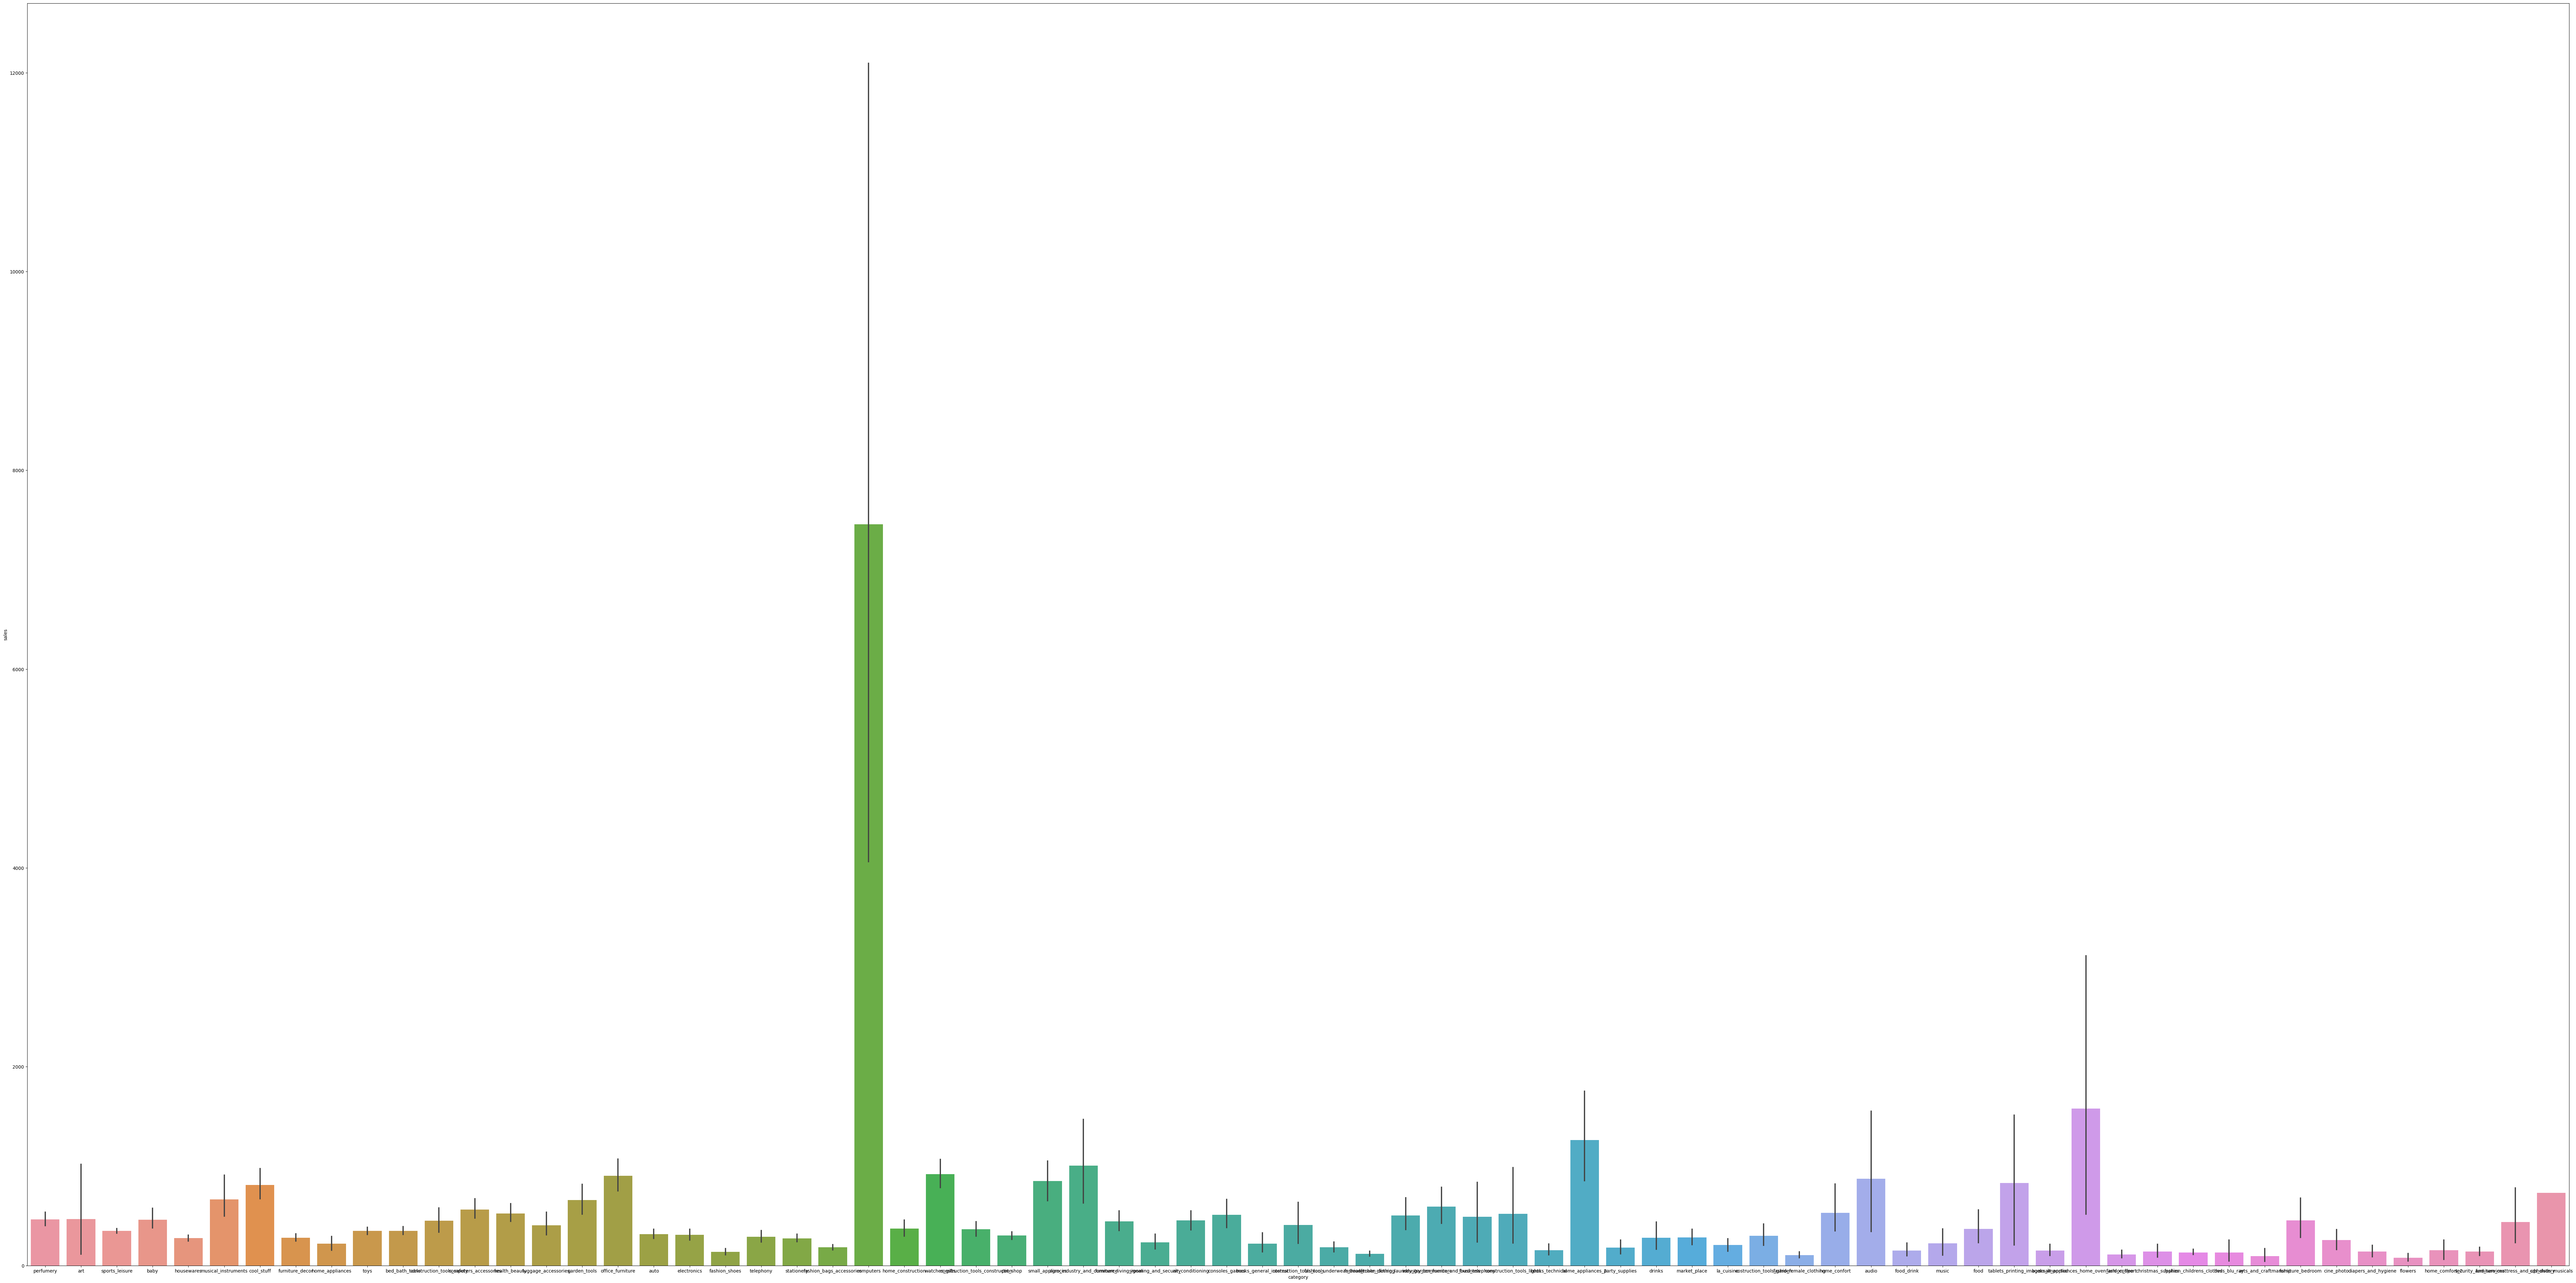

In [19]:
plt.figure(figsize=(100,50))
sns.barplot(data=products_table_clean, x="category", y="sales")

## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪